In [ ]:
#In case you don't have qiskit, install it now
%pip install qiskit --quiet
#Installing/upgrading pylatexenc seems to have fixed my mpl issue
#If you try this and it doesn't work, try also restarting the runtime/kernel
%pip install pylatexenc --quiet

In [ ]:
!pip install -Uqq ipdb
!pip install qiskit_optimization

     |████████████████████████████████| 793 kB 39.0 MB/s 
     |████████████████████████████████| 1.6 MB 40.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython~=7.9.0, but you have ipython 7.34.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 159 kB 9.5 MB/s 
     |████████████████████████████████| 640 kB 57.3 MB/s 
  Created wheel for docplex: filename=docplex-2.24.232-py3-none-any.whl size=682306 sha256=e1f0ae1d9cc90c49df77d8e84df1cde5393a335346f62fc803ec69ff753f1278
  Stored in directory: /root/.cache/pip/wheels/0a/fe/c3/3ea4d2ba91b08c1677a8d31550ab361443ec20e626fb1dd815
Successfully built docplex


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import BasicAer
from qiskit.compiler import transpile
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.quantum_info import process_fidelity
from qiskit.extensions.hamiltonian_gate import HamiltonianGate
from qiskit.extensions import RXGate, XGate, CXGate
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
import numpy as np
from qiskit.visualization import plot_histogram
import ipdb
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#quadratic optimization
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo

In [ ]:
%pdb on


Automatic pdb calling has been turned ON


In [ ]:
# def ApplyCost(qc, gamma):
#   Ix = np.array([[1,0],[0,1]])
#   Zx= np.array([[1,0],[0,-1]])
#   Xx = np.array([[0,1],[1,0]])
#   Temp = (Ix-Zx)/2
#   T = Operator(Temp)
#   I = Operator(Ix)
#   Z = Operator(Zx)
#   X = Operator(Xx)
#   FinalOp=-2*(T^I^T)-(I^T^T)-(T^I^I)+2*(I^T^I)-3*(I^I^T)
#   ham = HamiltonianGate(FinalOp,gamma)
#   qc.append(ham,[0,1,2])

In [ ]:
task = QuadraticProgram(name = 'QUBO on QC')
task.binary_var(name = 'x')
task.binary_var(name = 'y')
task.binary_var(name = 'z')
task.minimize(linear = {"x":-1,"y":2,"z":-3}, quadratic = {("x", "z"): -2, ("y", "z"): -1})
qubo = QuadraticProgramToQubo().convert(task) #convert to QUBO
operator, offset = qubo.to_ising()
print(operator)
# ham = HamiltonianGate(operator,0)
# print(ham)

1.0 * IIZ
- 0.75 * IZI
+ 2.25 * ZII
- 0.5 * ZIZ
- 0.25 * ZZI


In [ ]:
Ix = np.array([[1,0],[0,1]])
Zx= np.array([[1,0],[0,-1]])
Xx = np.array([[0,1],[1,0]])
Temp = (Ix-Zx)/2
T = Operator(Temp)
I = Operator(Ix)
Z = Operator(Zx)
X = Operator(Xx)
FinalOp=-2*(T^I^T)-(I^T^T)-(T^I^I)+2*(I^T^I)-3*(I^I^T)
ham = HamiltonianGate(FinalOp,0)
print(ham)

Instruction(name='hamiltonian', num_qubits=3, num_clbits=0, params=[array([[ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j],
       [ 0.+0.j, -3.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j],
       [ 0.+0.j,  0.+0.j,  2.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j, -2.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j, -6.+0.j,  0.+0.j,
         0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,
         0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        -5.+0.j]]), 0])


In [ ]:
#define PYBIND11_DETAILED_ERROR_MESSAGES
def compute_expectation(counts):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        x = int(bitstring[2])
        y = int(bitstring[1])
        z = int(bitstring[0])
        obj = -2*x*z-y*z-x+2*y-3*z
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = 3
    n,m=3,3
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits,nqubits)
    Ix = np.array([[1,0],[0,1]])
    Zx= np.array([[1,0],[0,-1]])
    Xx = np.array([[0,1],[1,0]])
    Temp = (Ix-Zx)/2
    T = Operator(Temp)
    I = Operator(Ix)
    Z = Operator(Zx)
    X = Operator(Xx)
    FinalOp=-2*(Z^I^Z)-(I^Z^Z)-(Z^I^I)+2*(I^Z^I)-3*(I^I^Z)
    beta = theta[:p]
    gamma = theta[p:]
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        #ipdb.set_trace(context=6)
        # problem unitary
        # for pair in list(G.edges()):
        #     qc.rzz(2 * gamma[irep], pair[0], pair[1])
        #ApplyCost(qc,2*0)
        ham = HamiltonianGate(operator,2 * gamma[irep])
        qc.append(ham,[0,1,2])
        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure(qc.qubits[:n],qc.clbits[:m])
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(theta)
        # ipdb.set_trace(context=6)
        counts = {}
        job = execute(qc, backend, shots=1024)
        result = job.result()
        counts=result.get_counts(qc)
        
        return compute_expectation(counts)
    
    return execute_circ

In [ ]:
from scipy.optimize import minimize
expectation = get_expectation()
res = minimize(expectation, [1, 1], method='COBYLA')


In [ ]:
expectation = get_expectation()
res = minimize(expectation, res.x, method='COBYLA')
res

     fun: -4.97265625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 30
  status: 1
 success: True
       x: array([2.25721263, 0.18439912])

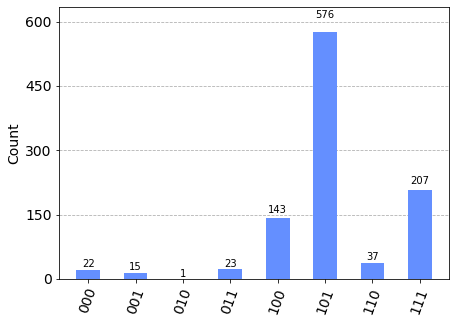

In [ ]:

from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(res.x)

backend = Aer.get_backend('qasm_simulator')
job = execute(qc_res, backend, shots=1024)
result = job.result()
counts=result.get_counts(qc_res)
plot_histogram(counts)